# Generate accept / reject dataset

### import packages

In [270]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
from collections import Counter
from copy import deepcopy

import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
 
# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, \
    AdaBoostClassifier, GradientBoostingRegressor, GradientBoostingClassifier, \
    ExtraTreesClassifier
from sklearn.model_selection import train_test_split #to create validation data set
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from pandas.tools.plotting import scatter_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder, Imputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_curve, auc, mean_squared_error, make_scorer
from sklearn import preprocessing, model_selection

import statsmodels.formula.api as sm

import utilities

from utilities.woe import woe_conversion, woe_graph, woe_analysis, mono_bin, char_bin
from utilities.scorecard import scorecard
from utilities.adverse_action import adverse_action

# pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)

#### Read in data

In [271]:
# data dictionary - https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)
# https://weclouddata.com/credit-scoring-with-machine-learning/

df = pd.read_csv('data/germancredit.csv')

In [272]:
df = df.rename(index=str, columns={"status.of.existing.checking.account": "checking_status", 
                              "duration.in.month": "duration",
                              "credit.history": "credit_history",
                              "credit.amount": "loan_amt",
                              "savings.account.and.bonds":"savings_status",
                              'present.employment.since':'emp_length',
                              'installment.rate.in.percentage.of.disposable.income':'rate_inc_perc',
                              'personal.status.and.sex':'gender_married',
                              'other.debtors.or.guarantors':'other_debtors',
                              'present.residence.since':'resid_length',
                              'property':'property_type',
                              'age.in.years':'age',
                              'other.installment.plans':'external_credit',
                              'number.of.existing.credits.at.this.bank':'internal_credit',
                              'job':'job_type',
                              'number.of.people.being.liable.to.provide.maintenance.for':'dependent_count',
                              'telephone':'has_phone',
                              'foreign.worker':'foreign_ind'
                             })

df['target'] = df['creditability'].map({'bad': 1, 'good': 0})
df['female'] = df['gender_married']
df['married'] = df['gender_married']
df = df.drop(['creditability', 'gender_married'], axis=1)

In [273]:
cleanup_var = {"checking_status": {"... < 0 DM": 0, 
                                   '0 <= ... < 200 DM':100,
                                   "... >= 200 DM / salary assignments for at least 1 year": 200,
                                   'no checking account': None},
                "savings_status": {"... < 100 DM": 100, 
                                   "100 <= ... < 500 DM": 500, 
                                   "500 <= ... < 1000 DM": 1000, 
                                   "... >= 1000 DM": 1500,
                                   "unknown/ no savings account": None},
                "emp_length":     {"unemployed": 0, 
                                   "... < 1 year": 1, 
                                   "1 <= ... < 4 years": 4, 
                                   "4 <= ... < 7 years": 7,
                                   "... >= 7 years": 10 },              
                "credit_history": {"all credits at this bank paid back duly": 'current_bank', 
                                   "critical account/ other credits existing (not at this bank)": 'current_other', 
                                   "delay in paying off in the past": 'delinquent', 
                                   "existing credits paid back duly till now": 'existing_current',
                                   "no credits taken/ all credits paid back duly": 'no_credit' },
                "has_phone":      {"yes, registered under the customers name": 1, 
                                   "none": 0},
                "property_type":  {"building society savings agreement/ life insurance": 'agreement', 
                                   "car or other, not in attribute Savings account/bonds": 'car',
                                   'real estate':'real_estate',
                                   'unknown / no property':'no_property'},
                "job_type":       {"management/ self-employed/ highly qualified employee/ officer": 'management', 
                                   "skilled employee / official": 'skilled', 
                                   "unemployed/ unskilled - non-resident": 'unskilled_resid', 
                                   "unskilled - resident": 'unskilled_nonresid'},
                "foreign_ind":    {"yes": 1, 
                                   "no": 0},
                "female":         {"female : divorced/separated/married": 1, 
                                   "male : married/widowed": 0,
                                   'male : single':0},
                "married":        {"female : divorced/separated/married": 1, 
                                   "male : married/widowed": 1,
                                   'male : single':0},
              }

df.replace(cleanup_var, inplace=True) 
# df.head()

                 MIN_VALUE  MAX_VALUE
Bucket                               
(-0.001, 100.0]        0.0      100.0
(100.0, 200.0]       200.0      200.0


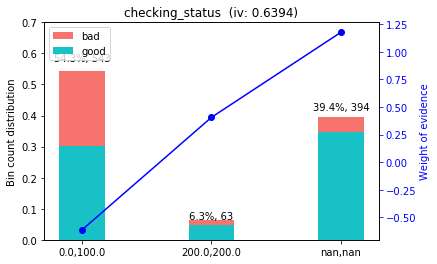

               MIN_VALUE  MAX_VALUE
Bucket                             
(3.999, 12.0]          4         12
(12.0, 24.0]          13         24
(24.0, 72.0]          26         72


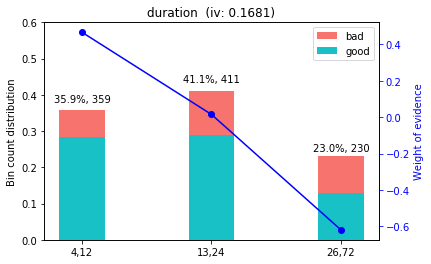

                  COUNT
X                      
current_bank         49
current_other       293
delinquent           88
existing_current    530
no_credit            40


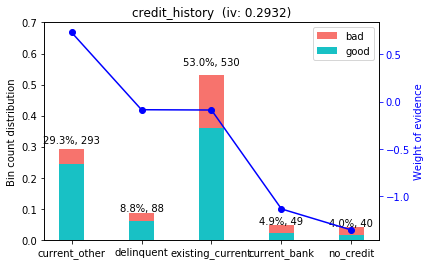

                     COUNT
X                         
business                97
car (new)              234
car (used)             103
domestic appliances     12
education               50
furniture/equipment    181
others                  12
radio/television       280
repairs                 22
retraining               9


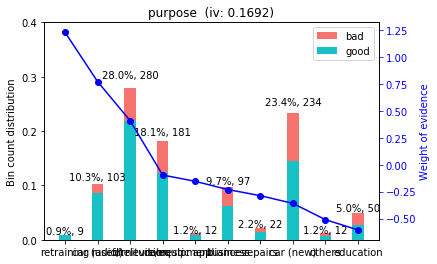

                   MIN_VALUE  MAX_VALUE
Bucket                                 
(249.999, 2319.5]        250       2319
(2319.5, 18424.0]       2320      18424


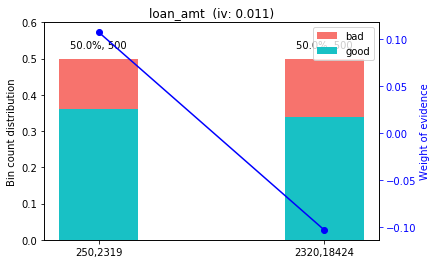

                 MIN_VALUE  MAX_VALUE
Bucket                               
(0.999, 50.0]          NaN        NaN
(50.0, 100.0]        100.0      100.0
(100.0, 1500.0]      500.0     1500.0


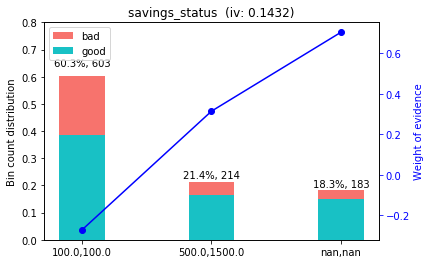

               MIN_VALUE  MAX_VALUE
Bucket                             
(-0.001, 4.0]          0          4
(4.0, 10.0]            7         10


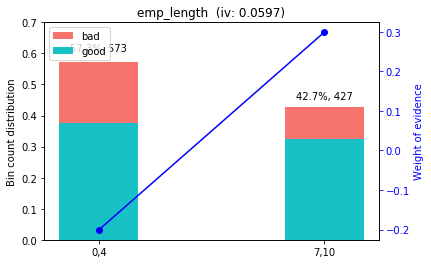

              MIN_VALUE  MAX_VALUE
Bucket                            
(0.999, 3.0]          1          3
(3.0, 4.0]            4          4


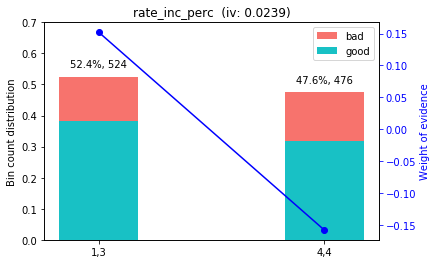

              COUNT
X                  
co-applicant     41
guarantor        52
none            907


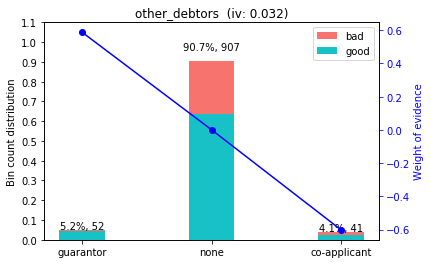

              MIN_VALUE  MAX_VALUE
Bucket                            
(0.999, 3.0]          1          3
(3.0, 4.0]            4          4


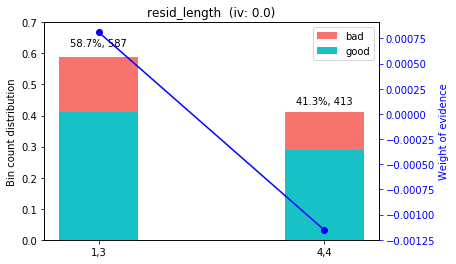

             COUNT
X                 
agreement      232
car            332
no_property    154
real_estate    282


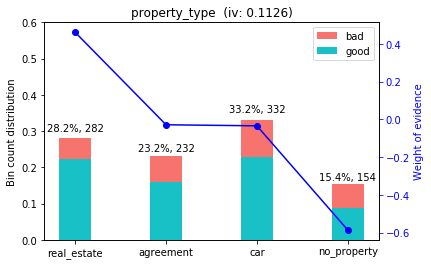

                MIN_VALUE  MAX_VALUE
Bucket                              
(18.999, 28.0]         19         28
(28.0, 38.0]           29         38
(38.0, 75.0]           39         75


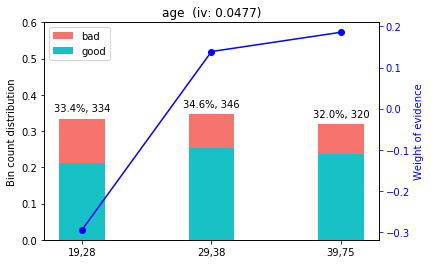

        COUNT
X            
bank      139
none      814
stores     47


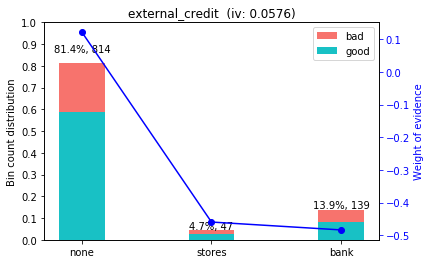

          COUNT
X              
for free    108
own         713
rent        179


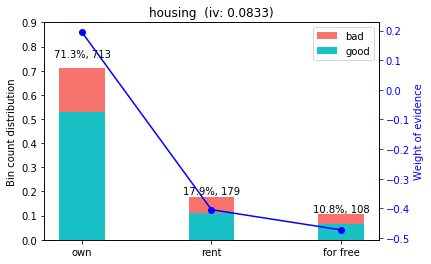

              MIN_VALUE  MAX_VALUE
Bucket                            
(0.499, 1.0]          1          1
(1.0, 4.0]            2          4


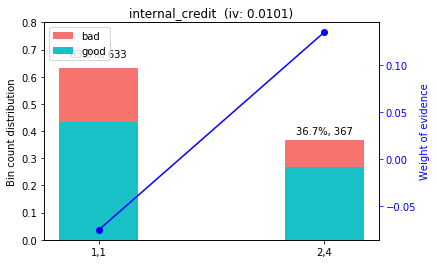

                    COUNT
X                        
management            148
skilled               630
unskilled_nonresid    200
unskilled_resid        22


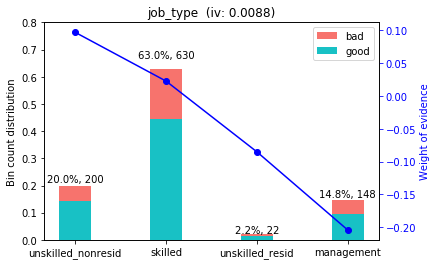

   COUNT
X       
1    845
2    155


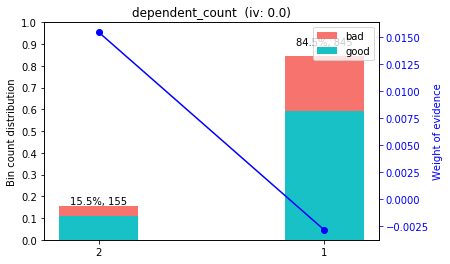

   COUNT
X       
0    596
1    404


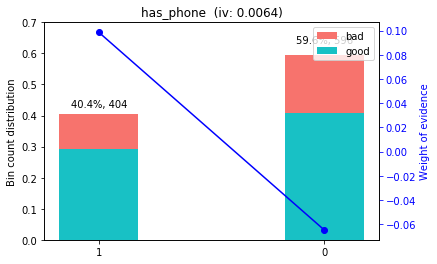

   COUNT
X       
0     37
1    963


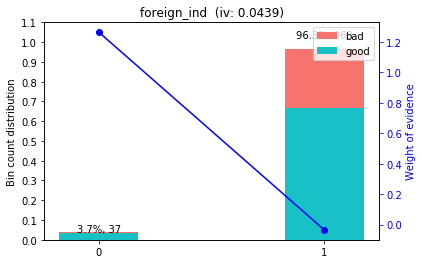

   COUNT
X       
0    640
1    360


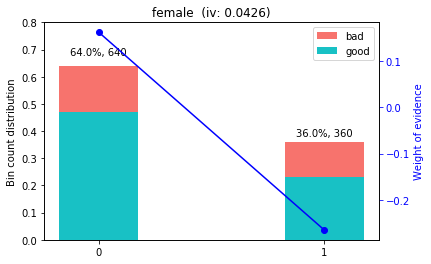

   COUNT
X       
0    548
1    452


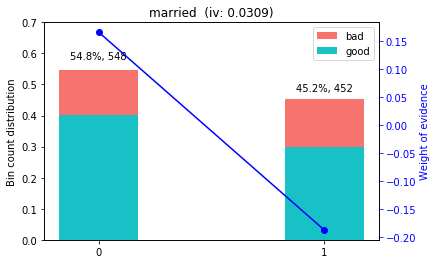

In [274]:
X = df.drop(['target'], axis=1)
y = df['target'] 

final_iv, IV = woe_analysis(X, y, 20, 3)

In [275]:
# X_vars = ['resid_length', 'dependent_count', 'has_phone', 'internal_credit', \
#                               'rate_inc_perc', 'other_debtors', 'job_type', 'loan_amt', 'foreign_ind',\
#                              'married', 'female', 'external_credit', 'emp_length', 'savings_status',
#                              'age']

X_vars = ['resid_length', 'dependent_count', 'has_phone', 'internal_credit', \
                              'rate_inc_perc', 'other_debtors', 'job_type', 'married', 'female', 'age']

X_clean = X.drop(X_vars,axis=1)

#### Convert training data to WOE values

In [276]:
X_woe = woe_conversion(X_clean, final_iv)


#### Perform grid search for logistic regression hyperparameters

In [277]:
kfold = StratifiedKFold(n_splits=10)

param_grid_logistic = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                       'penalty': ['l1', 'l2']}
 
clf_logistic = GridSearchCV(estimator=LogisticRegression(random_state=1), param_grid=param_grid_logistic, cv= kfold)
clf_logistic.fit(X_woe, y)
 
logistic_final = clf_logistic.best_estimator_
print(clf_logistic.best_score_, clf_logistic.best_params_)
print(logistic_final)

0.755 {'C': 0.1, 'penalty': 'l2'}
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


#### Fit logistic regression model and calculate AUROC

In [278]:
logreg_clf = LogisticRegression(penalty = 'l2', C=0.1)
logreg_clf.fit(X_woe, y)

# pred_logreg = logreg_clf.predict(X_woe)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### Generate credit score for all observations, and generate score table

In [279]:
X_score_tab, X_scored = scorecard(X_woe, logreg_clf, final_iv, 600, 50, 20)

In [280]:
X_scored

,checking_status_score,duration_score,credit_history_score,purpose_score,loan_amt_score,savings_status_score,emp_length_score,property_type_score,external_credit_score,housing_score,foreign_ind_score,neutral,total_score
0,32.976833,55.290203,59.309836,54.330379,45.771774,58.218238,49.781883,51.507024,47.464744,48.168204,45.909058,46.295078,548.728177
1,32.976833,34.358936,44.728522,54.330379,46.796864,41.700884,43.949904,51.507024,47.464744,48.168204,45.909058,46.295078,491.891352
2,71.800874,55.290203,59.309836,34.417670,45.771774,41.700884,49.781883,51.507024,47.464744,48.168204,45.909058,46.295078,551.122155
3,32.976833,34.358936,44.728522,44.422620,46.796864,41.700884,49.781883,45.972059,47.464744,41.735612,45.909058,46.295078,475.848016
4,32.976833,46.585818,44.784587,39.256439,46.796864,41.700884,43.949904,39.669486,47.464744,41.735612,45.909058,46.295078,470.830229
5,71.800874,34.358936,44.728522,34.417670,46.796864,58.218238,43.949904,39.669486,47.464744,41.735612,45.909058,46.295078,509.049907
6,71.800874,46.585818,44.728522,44.422620,46.796864,51.621830,49.781883,45.972059,47.464744,48.168204,45.909058,46.295078,543.252477
7,32.976833,34.358936,44.728522,61.458622,46.796864,41.700884,43.949904,45.908548,47.464744,42.393180,45.909058,46.295078,487.646096
8,71.800874,55.290203,44.728522,54.330379,46.796864,51.621830,49.781883,51.507024,47.464744,48.168204,45.909058,46.295078,567.399586
9,32.976833,34.358936,59.309836,39.256439,46.796864,41.700884,43.949904,45.908548,47.464744,48.168204,45.909058,46.295078,485.800251


In [281]:
score = X_scored[['total_score']]

In [282]:
df_full = pd.concat([df, score], axis=1)

In [283]:
df_full.describe()
df_full.quantile([.1, .2])
# total_score min = 439
# total_score 10th percentile = 476
# total_score 20th percentile = 489

,checking_status,duration,loan_amt,savings_status,emp_length,rate_inc_perc,resid_length,age,internal_credit,dependent_count,has_phone,foreign_ind,target,female,married,total_score
0.1,0.0,9.0,932.0,100.0,1.0,1.0,1.0,23.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,476.448629
0.2,0.0,12.0,1262.0,100.0,1.0,2.0,2.0,26.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,489.293298


In [284]:
df_full['hard_reject'] = np.where(df_full['total_score']>=476, 0, 1)
df_full['pct20'] = np.where(df_full['total_score']>=489, 0, 1)

np.random.seed(1234)
df_full['randNum'] = np.random.uniform(0, 1, df_full.shape[0])
df_full['override'] = np.where((df_full['pct20']==1) & (df_full['randNum'] < 0.15), 1, 0)

# print(df_full['override'].value_counts())

df_full['reject'] = np.where((((df_full['hard_reject'] == 1) & (df_full['override'] == 0)) |
                            ((df_full['hard_reject'] == 0) & (df_full['override'] == 1))),1,0)

In [285]:
df_full['total_score'].groupby(df_full['reject']).describe()

,count,mean,std,min,25%,50%,75%,max
reject,,,,,,,,
0,908.0,521.250448,27.409513,451.274129,498.474151,518.552842,543.651932,588.577307
1,92.0,466.011473,10.657157,439.203087,459.689857,466.551673,473.740398,488.548426


In [286]:
reject = df_full[df_full.reject == 1]
reject = reject.drop(['hard_reject', 'pct20', 'randNum', 'override', 'reject', 'total_score'], axis=1)

accept = df_full[df_full.reject == 0]
accept = accept.drop(['hard_reject', 'pct20', 'randNum', 'override', 'reject', 'total_score'], axis=1)

In [293]:
accept.to_csv('data/germancredit_accept.csv', index=False)
reject.to_csv('data/germancredit_reject.csv', index=False)